In [1]:
# importing our functions
from utilities import coords_to_bins, add_previous_event_time, add_possession_duration, add_team_possession, adjust_eventSec, add_adjusted_eventSec, adjust_eventSec_for_match
#%pip install xgboost
#%pip install tabulate
# Importing  libraries
import xgboost as xgb
import numpy as np 
import pandas as pd
import seaborn as sns
import json
#Plotting
import matplotlib.pyplot as plt
#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
# Importing the libraries required for logistic regression , random forests  

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, brier_score_loss
# Loading required libraries for cross validation 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score


from tabulate import tabulate
from scipy.stats import norm
import pickle

In [2]:
# load data - store it in train dataframe

# Loading data for the English League
with open('events_England.json') as f:
    data_England = json.load(f)

# Converting the laoded into datframe
event_England = pd.DataFrame(data_England)
event_England['score_17_18'] = 79.605

event_England



,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
643145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409,79.605
643146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232,79.605
643147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410,79.605
643148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234,79.605


In [3]:
# Loading data for the English League
with open('events_Spain.json') as f:
    data_Spain = json.load(f)

# Converting the laoded into datframe
event_Spain = pd.DataFrame(data_Spain)
event_Spain['score_17_18'] = 106.998

event_Spain

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419,106.998
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418,106.998
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420,106.998
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421,106.998
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422,106.998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
628654,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671,106.998
628655,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673,106.998
628656,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674,106.998
628657,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698,106.998


In [4]:
# Loading data for the English League
with open('events_Italy.json') as f:
    data_Italy = json.load(f)

# Converting the laoded into datframe
event_Italy = pd.DataFrame(data_Italy)
event_Italy['score_17_18'] = 76.249

event_Italy

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,2.530536,85,180423957,76.249
1,8,Simple pass,[{'id': 1801}],20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",2575959,Pass,3158,1H,3.768418,85,180423958,76.249
2,7,Touch,[],8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",2575959,Others on the ball,3158,1H,4.868265,72,180423959,76.249
3,1,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 56, 'x': 78}, {'y': 15, 'x': 64}]",2575959,Duel,3158,1H,8.114676,11,180423960,76.249
4,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 15, 'x': 64}, {'y': 15, 'x': 72}]",2575959,Duel,3158,1H,8.647892,11,180423961,76.249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
647367,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249
647368,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13,253567161,76.249
647369,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249
647370,1,Air duel,"[{'id': 703}, {'id': 1801}]",20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10,253567162,76.249


In [5]:
# Loading data for the English League
with open('events_Germany.json') as f:
    data_Germany = json.load(f)

# Converting the laoded into datframe
event_Germany = pd.DataFrame(data_Germany)
event_Germany['score_17_18'] = 71.427

event_Germany

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],15231,"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",2516739,Pass,2446,1H,2.409746,85,179896442,71.427
1,8,Simple pass,[{'id': 1801}],14786,"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",2516739,Pass,2446,1H,2.506082,85,179896443,71.427
2,8,Simple pass,[{'id': 1801}],14803,"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",2516739,Pass,2446,1H,6.946706,85,179896444,71.427
3,8,Simple pass,[{'id': 1801}],14768,"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",2516739,Pass,2446,1H,10.786491,85,179896445,71.427
4,8,Simple pass,[{'id': 1801}],14803,"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",2516739,Pass,2446,1H,12.684514,85,179896446,71.427
...,...,...,...,...,...,...,...,...,...,...,...,...,...
519402,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",15317,"[{'y': 9, 'x': 91}, {'y': 6, 'x': 90}]",2517044,Duel,2463,2H,2825.097992,11,251206867,71.427
519403,1,Ground defending duel,"[{'id': 703}, {'id': 1801}]",14804,"[{'y': 94, 'x': 10}, {'y': 95, 'x': 0}]",2517044,Duel,2451,2H,2825.519102,12,251206788,71.427
519404,1,Ground attacking duel,"[{'id': 701}, {'id': 1802}]",15317,"[{'y': 6, 'x': 90}, {'y': 5, 'x': 100}]",2517044,Duel,2463,2H,2826.053788,11,251206868,71.427
519405,8,Simple pass,[{'id': 1802}],14804,"[{'y': 95, 'x': 0}, {'y': 93, 'x': 5}]",2517044,Pass,2451,2H,2828.080925,85,251206790,71.427


In [6]:
# Loading data for the French League
with open('events_France.json') as f:
    data_France = json.load(f)

# Converting the laoded into datframe
event_France = pd.DataFrame(data_France)
event_France['score_17_18'] = 56.415

event_France

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],253784,"[{'y': 51, 'x': 50}, {'y': 46, 'x': 31}]",2500686,Pass,3799,1H,1.935181,85,176505119,56.415
1,8,High pass,[{'id': 1801}],29474,"[{'y': 46, 'x': 31}, {'y': 74, 'x': 68}]",2500686,Pass,3799,1H,3.599295,83,176505121,56.415
2,1,Air duel,"[{'id': 703}, {'id': 1801}]",253784,"[{'y': 74, 'x': 68}, {'y': 54, 'x': 72}]",2500686,Duel,3799,1H,6.827043,10,176505122,56.415
3,1,Air duel,"[{'id': 701}, {'id': 1802}]",56441,"[{'y': 26, 'x': 32}, {'y': 46, 'x': 28}]",2500686,Duel,3772,1H,6.985577,10,176505017,56.415
4,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",366760,"[{'y': 54, 'x': 72}, {'y': 55, 'x': 73}]",2500686,Duel,3799,1H,9.511272,11,176505124,56.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632802,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",405977,"[{'y': 65, 'x': 87}, {'y': 100, 'x': 100}]",2501065,Shot,19830,2H,2821.203869,100,253316980,56.415
632803,9,Save attempt,"[{'id': 101}, {'id': 1208}, {'id': 1802}]",25521,"[{'y': 0, 'x': 0}, {'y': 35, 'x': 13}]",2501065,Save attempt,3795,2H,2824.817116,91,253316978,56.415
632804,8,Simple pass,[{'id': 1801}],295761,"[{'y': 52, 'x': 50}, {'y': 47, 'x': 44}]",2501065,Pass,3795,2H,2888.383858,85,253316981,56.415
632805,8,Simple pass,[{'id': 1801}],249926,"[{'y': 47, 'x': 44}, {'y': 8, 'x': 41}]",2501065,Pass,3795,2H,2889.654402,85,253316982,56.415


In [7]:
event_data = pd.concat([event_England, event_France, event_Germany, event_Italy, event_Spain])

# Reset the index of the resulting dataframe
event_data = event_data.reset_index(drop=True)
event_data


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671,106.998
3071391,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673,106.998
3071392,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674,106.998
3071393,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698,106.998


In [8]:
event_data.head(30)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605
5,8,Simple pass,[{'id': 1802}],3319,"[{'y': 88, 'x': 72}, {'y': 75, 'x': 77}]",2499719,Pass,1609,1H,12.548934,85,177959177,79.605
6,8,Head pass,[{'id': 1801}],8653,"[{'y': 25, 'x': 23}, {'y': 15, 'x': 39}]",2499719,Pass,1631,1H,13.961228,82,177959186,79.605
7,1,Air duel,"[{'id': 701}, {'id': 1802}]",8013,"[{'y': 15, 'x': 39}, {'y': 20, 'x': 33}]",2499719,Duel,1631,1H,14.765321,10,177959189,79.605
8,1,Air duel,"[{'id': 703}, {'id': 1801}]",0,"[{'y': 85, 'x': 61}, {'y': 80, 'x': 67}]",2499719,Duel,1609,1H,14.765321,10,177961218,79.605
9,8,Head pass,"[{'id': 1401}, {'id': 1801}]",167145,"[{'y': 80, 'x': 67}, {'y': 61, 'x': 59}]",2499719,Pass,1609,1H,15.320341,82,177959178,79.605


In [9]:
data = add_adjusted_eventSec(event_data)
data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,2.758649
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,4.946850
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,6.542188
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,8.143395
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,10.302366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671,106.998,5646.463117
3071391,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673,106.998,5647.901186
3071392,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674,106.998,5649.484387
3071393,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698,106.998,5650.474858


In [10]:
# vérifier si le temps s'accumule en changeant de période
data.iloc[900:910]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec
900,8,Simple pass,[{'id': 1802}],14853,"[{'y': 24, 'x': 31}, {'y': 100, 'x': 100}]",2499719,Pass,1631,1H,2852.557381,85,177960127,79.605,2852.557381
901,8,Simple pass,[{'id': 1801}],14763,"[{'y': 50, 'x': 50}, {'y': 42, 'x': 38}]",2499719,Pass,1631,2H,2.836169,85,177960135,79.605,2855.393550
902,8,High pass,[{'id': 1802}],8653,"[{'y': 42, 'x': 38}, {'y': 16, 'x': 74}]",2499719,Pass,1631,2H,5.311682,83,177960136,79.605,2857.869063
903,8,Head pass,"[{'id': 1401}, {'id': 1801}]",167145,"[{'y': 84, 'x': 26}, {'y': 68, 'x': 32}]",2499719,Pass,1609,2H,8.449574,82,177960133,79.605,2861.006955
904,8,Simple pass,[{'id': 1802}],49876,"[{'y': 68, 'x': 32}, {'y': 100, 'x': 27}]",2499719,Pass,1609,2H,10.458703,85,177960134,79.605,2863.016084
905,5,Ball out of the field,[],0,"[{'y': 0, 'x': 73}, {'y': 100, 'x': 100}]",2499719,Interruption,1631,2H,14.254189,50,177960144,79.605,2866.811570
906,3,Throw in,[{'id': 1801}],14853,"[{'y': 0, 'x': 78}, {'y': 38, 'x': 92}]",2499719,Free Kick,1631,2H,68.151051,36,177960146,79.605,2920.708432
907,1,Air duel,"[{'id': 702}, {'id': 1801}]",8653,"[{'y': 38, 'x': 92}, {'y': 37, 'x': 89}]",2499719,Duel,1631,2H,71.963210,10,177960148,79.605,2924.520591
908,1,Air duel,"[{'id': 702}, {'id': 1801}]",0,"[{'y': 62, 'x': 8}, {'y': 63, 'x': 11}]",2499719,Duel,1609,2H,71.963210,10,177961253,79.605,2924.520591
909,1,Air duel,"[{'id': 702}, {'id': 1801}]",8653,"[{'y': 37, 'x': 89}, {'y': 30, 'x': 85}]",2499719,Duel,1631,2H,72.144350,10,177960151,79.605,2924.701731


In [11]:
data = add_team_possession(data)
data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec,possession_duration,team_possession
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,2.758649,2.758649,2.758649
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,4.946850,2.188201,4.946850
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,6.542188,1.595338,6.542188
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,8.143395,1.601207,8.143395
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,10.302366,2.158971,10.302366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442727,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",116269,"[{'y': 15, 'x': 78}, {'y': 18, 'x': 74}]",2576338,Duel,3193,2H,2818.237165,11,253567151,76.249,5693.313549,0.627653,3475.451269
2442728,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",116269,"[{'y': 18, 'x': 74}, {'y': 13, 'x': 76}]",2576338,Duel,3193,2H,2823.098572,11,253567155,76.249,5698.174956,4.861407,3480.312676
2442731,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249,5746.059044,46.240805,3526.553481
2442733,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249,5748.066821,0.889295,3527.442776


In [12]:
data.head(20)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec,possession_duration,team_possession
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,2.758649,2.758649,2.758649
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,4.946850,2.188201,4.946850
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,6.542188,1.595338,6.542188
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,8.143395,1.601207,8.143395
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,10.302366,2.158971,10.302366
5,8,Simple pass,[{'id': 1802}],3319,"[{'y': 88, 'x': 72}, {'y': 75, 'x': 77}]",2499719,Pass,1609,1H,12.548934,85,177959177,79.605,12.548934,2.246568,12.548934
8,1,Air duel,"[{'id': 703}, {'id': 1801}]",0,"[{'y': 85, 'x': 61}, {'y': 80, 'x': 67}]",2499719,Duel,1609,1H,14.765321,10,177961218,79.605,14.765321,0.000000,12.548934
9,8,Head pass,"[{'id': 1401}, {'id': 1801}]",167145,"[{'y': 80, 'x': 67}, {'y': 61, 'x': 59}]",2499719,Pass,1609,1H,15.320341,82,177959178,79.605,15.320341,0.555020,13.103954
10,8,Head pass,[{'id': 1801}],49876,"[{'y': 61, 'x': 59}, {'y': 45, 'x': 45}]",2499719,Pass,1609,1H,18.051875,82,177959179,79.605,18.051875,2.731534,15.835488
11,8,High pass,[{'id': 1801}],14869,"[{'y': 45, 'x': 45}, {'y': 54, 'x': 71}]",2499719,Pass,1609,1H,20.426527,83,177959180,79.605,20.426527,2.374652,18.210140


In [13]:
data['possession_percent'] = data['team_possession']/data['adjusted_eventSec']

data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec,possession_duration,team_possession,possession_percent
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,2.758649,2.758649,2.758649,1.000000
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,4.946850,2.188201,4.946850,1.000000
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,6.542188,1.595338,6.542188,1.000000
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,8.143395,1.601207,8.143395,1.000000
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,10.302366,2.158971,10.302366,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442727,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",116269,"[{'y': 15, 'x': 78}, {'y': 18, 'x': 74}]",2576338,Duel,3193,2H,2818.237165,11,253567151,76.249,5693.313549,0.627653,3475.451269,0.610444
2442728,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",116269,"[{'y': 18, 'x': 74}, {'y': 13, 'x': 76}]",2576338,Duel,3193,2H,2823.098572,11,253567155,76.249,5698.174956,4.861407,3480.312676,0.610777
2442731,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249,5746.059044,46.240805,3526.553481,0.613734
2442733,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249,5748.066821,0.889295,3527.442776,0.613675


In [14]:
data.head(30)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec,possession_duration,team_possession,possession_percent
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,2.758649,2.758649,2.758649,1.000000
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,4.946850,2.188201,4.946850,1.000000
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,6.542188,1.595338,6.542188,1.000000
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,8.143395,1.601207,8.143395,1.000000
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,10.302366,2.158971,10.302366,1.000000
5,8,Simple pass,[{'id': 1802}],3319,"[{'y': 88, 'x': 72}, {'y': 75, 'x': 77}]",2499719,Pass,1609,1H,12.548934,85,177959177,79.605,12.548934,2.246568,12.548934,1.000000
8,1,Air duel,"[{'id': 703}, {'id': 1801}]",0,"[{'y': 85, 'x': 61}, {'y': 80, 'x': 67}]",2499719,Duel,1609,1H,14.765321,10,177961218,79.605,14.765321,0.000000,12.548934,0.849892
9,8,Head pass,"[{'id': 1401}, {'id': 1801}]",167145,"[{'y': 80, 'x': 67}, {'y': 61, 'x': 59}]",2499719,Pass,1609,1H,15.320341,82,177959178,79.605,15.320341,0.555020,13.103954,0.855330
10,8,Head pass,[{'id': 1801}],49876,"[{'y': 61, 'x': 59}, {'y': 45, 'x': 45}]",2499719,Pass,1609,1H,18.051875,82,177959179,79.605,18.051875,2.731534,15.835488,0.877221
11,8,High pass,[{'id': 1801}],14869,"[{'y': 45, 'x': 45}, {'y': 54, 'x': 71}]",2499719,Pass,1609,1H,20.426527,83,177959180,79.605,20.426527,2.374652,18.210140,0.891495


In [15]:
#changement de mi-temps(1ère équipe)
data.iloc[530:540]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec,possession_duration,team_possession,possession_percent
895,10,Shot,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",25413,"[{'y': 48, 'x': 87}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,2813.844402,100,177960131,79.605,2813.844402,1.303491,1515.903740,0.538730
897,8,Simple pass,"[{'id': 301}, {'id': 1801}]",14869,"[{'y': 39, 'x': 89}, {'y': 50, 'x': 92}]",2499719,Pass,1609,1H,2814.484544,85,177960129,79.605,2814.484544,0.470022,1516.373762,0.538775
898,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",7945,"[{'y': 50, 'x': 92}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,2815.900791,100,177960130,79.605,2815.900791,1.416247,1517.790009,0.539007
903,8,Head pass,"[{'id': 1401}, {'id': 1801}]",167145,"[{'y': 84, 'x': 26}, {'y': 68, 'x': 32}]",2499719,Pass,1609,2H,8.449574,82,177960133,79.605,2861.006955,3.137892,1520.927901,0.531606
904,8,Simple pass,[{'id': 1802}],49876,"[{'y': 68, 'x': 32}, {'y': 100, 'x': 27}]",2499719,Pass,1609,2H,10.458703,85,177960134,79.605,2863.016084,2.009129,1522.937030,0.531935
908,1,Air duel,"[{'id': 702}, {'id': 1801}]",0,"[{'y': 62, 'x': 8}, {'y': 63, 'x': 11}]",2499719,Duel,1609,2H,71.963210,10,177961253,79.605,2924.520591,0.000000,1522.937030,0.520748
910,1,Air duel,"[{'id': 702}, {'id': 1801}]",7945,"[{'y': 63, 'x': 11}, {'y': 70, 'x': 15}]",2499719,Duel,1609,2H,72.573831,10,177960138,79.605,2925.131212,0.429481,1523.366511,0.520786
912,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",25413,"[{'y': 70, 'x': 15}, {'y': 76, 'x': 8}]",2499719,Duel,1609,2H,74.142945,13,177960139,79.605,2926.700326,0.822771,1524.189282,0.520788
913,8,High pass,[{'id': 1802}],370224,"[{'y': 76, 'x': 8}, {'y': 75, 'x': 44}]",2499719,Pass,1609,2H,77.088925,83,177960140,79.605,2929.646306,2.945980,1527.135262,0.521269
917,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",370224,"[{'y': 72, 'x': 26}, {'y': 79, 'x': 18}]",2499719,Duel,1609,2H,83.010922,13,177960141,79.605,2935.568303,0.139322,1527.274584,0.520265


In [16]:
#changement d'équipe
data.iloc[1030:1040]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec,possession_duration,team_possession,possession_percent
1764,8,Head pass,[{'id': 1801}],49876,"[{'y': 51, 'x': 54}, {'y': 58, 'x': 73}]",2499719,Pass,1609,2H,2994.900590,82,177961035,79.605,5847.457971,2.409015,2943.004330,0.503296
1765,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1216}, {'id'...",7870,"[{'y': 58, 'x': 73}, {'y': 0, 'x': 0}]",2499719,Shot,1609,2H,2997.086392,100,177961036,79.605,5849.643773,2.185802,2945.190132,0.503482
6,8,Head pass,[{'id': 1801}],8653,"[{'y': 25, 'x': 23}, {'y': 15, 'x': 39}]",2499719,Pass,1631,1H,13.961228,82,177959186,79.605,13.961228,1.412294,1.412294,0.101158
7,1,Air duel,"[{'id': 701}, {'id': 1802}]",8013,"[{'y': 15, 'x': 39}, {'y': 20, 'x': 33}]",2499719,Duel,1631,1H,14.765321,10,177959189,79.605,14.765321,0.804093,2.216387,0.150108
12,1,Air duel,"[{'id': 703}, {'id': 1801}]",8653,"[{'y': 46, 'x': 29}, {'y': 41, 'x': 50}]",2499719,Duel,1631,1H,21.878309,10,177959191,79.605,21.878309,1.451782,3.668169,0.167662
15,8,Head pass,[{'id': 1801}],8653,"[{'y': 31, 'x': 24}, {'y': 15, 'x': 42}]",2499719,Pass,1631,1H,25.904249,82,177959194,79.605,25.904249,1.315939,4.984108,0.192405
16,8,Head pass,[{'id': 1801}],8013,"[{'y': 15, 'x': 42}, {'y': 26, 'x': 29}]",2499719,Pass,1631,1H,27.527696,82,177959195,79.605,27.527696,1.623447,6.607555,0.240033
17,8,Simple pass,[{'id': 1801}],265366,"[{'y': 26, 'x': 29}, {'y': 8, 'x': 37}]",2499719,Pass,1631,1H,29.980898,85,177959196,79.605,29.980898,2.453202,9.060757,0.302218
18,8,Simple pass,[{'id': 1801}],8013,"[{'y': 8, 'x': 37}, {'y': 5, 'x': 23}]",2499719,Pass,1631,1H,31.163870,85,177959197,79.605,31.163870,1.182972,10.243729,0.328705
19,8,High pass,[{'id': 1802}],14853,"[{'y': 5, 'x': 23}, {'y': 19, 'x': 63}]",2499719,Pass,1631,1H,32.805618,83,177959202,79.605,32.805618,1.641748,11.885477,0.362300


In [17]:
#changement de mi-temps(2ème équipe)
data.iloc[1395:1420]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec,possession_duration,team_possession,possession_percent
888,1,Ground attacking duel,"[{'id': 504}, {'id': 602}, {'id': 701}, {'id':...",26150,"[{'y': 72, 'x': 33}, {'y': 70, 'x': 34}]",2499719,Duel,1631,1H,2803.416016,11,177960112,79.605,2803.416016,0.006148,1297.836437,0.462948
894,1,Ground defending duel,"[{'id': 701}, {'id': 1802}]",8488,"[{'y': 56, 'x': 15}, {'y': 52, 'x': 13}]",2499719,Duel,1631,1H,2812.540911,12,177960116,79.605,2812.540911,0.104225,1297.940662,0.461483
896,7,Touch,[{'id': 1401}],8653,"[{'y': 49, 'x': 14}, {'y': 61, 'x': 11}]",2499719,Others on the ball,1631,1H,2814.014522,72,177960132,79.605,2814.014522,0.170120,1298.110782,0.461302
899,9,Reflexes,"[{'id': 101}, {'id': 1203}, {'id': 1802}]",8480,"[{'y': 100, 'x': 100}, {'y': 50, 'x': 8}]",2499719,Save attempt,1631,1H,2817.604704,90,177960121,79.605,2817.604704,1.703913,1299.814695,0.461319
900,8,Simple pass,[{'id': 1802}],14853,"[{'y': 24, 'x': 31}, {'y': 100, 'x': 100}]",2499719,Pass,1631,1H,2852.557381,85,177960127,79.605,2852.557381,34.952677,1334.767372,0.467920
901,8,Simple pass,[{'id': 1801}],14763,"[{'y': 50, 'x': 50}, {'y': 42, 'x': 38}]",2499719,Pass,1631,2H,2.836169,85,177960135,79.605,2855.393550,2.836169,1337.603541,0.468448
902,8,High pass,[{'id': 1802}],8653,"[{'y': 42, 'x': 38}, {'y': 16, 'x': 74}]",2499719,Pass,1631,2H,5.311682,83,177960136,79.605,2857.869063,2.475513,1340.079054,0.468908
905,5,Ball out of the field,[],0,"[{'y': 0, 'x': 73}, {'y': 100, 'x': 100}]",2499719,Interruption,1631,2H,14.254189,50,177960144,79.605,2866.811570,3.795486,1343.874540,0.468770
906,3,Throw in,[{'id': 1801}],14853,"[{'y': 0, 'x': 78}, {'y': 38, 'x': 92}]",2499719,Free Kick,1631,2H,68.151051,36,177960146,79.605,2920.708432,53.896862,1397.771402,0.478573
907,1,Air duel,"[{'id': 702}, {'id': 1801}]",8653,"[{'y': 38, 'x': 92}, {'y': 37, 'x': 89}]",2499719,Duel,1631,2H,71.963210,10,177960148,79.605,2924.520591,3.812159,1401.583561,0.479252


In [18]:
#changement de match
data.iloc[1765:1775]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec,possession_duration,team_possession,possession_percent
1763,8,Launch,[{'id': 1802}],8480,"[{'y': 53, 'x': 7}, {'y': 49, 'x': 46}]",2499719,Pass,1631,2H,2992.491575,84,177961040,79.605,5845.048956,1.723374,2904.453641,0.496908
1766,5,Ball out of the field,[],0,"[{'y': 48, 'x': 3}, {'y': 100, 'x': 100}]",2499719,Interruption,1631,2H,2998.963701,50,177961041,79.605,5851.521082,1.877309,2906.330950,0.496680
1767,3,Goal kick,[],8480,"[{'y': 100, 'x': 100}, {'y': 100, 'x': 100}]",2499719,Free Kick,1631,2H,3006.647279,34,177961042,79.605,5859.204660,7.683578,2914.014528,0.497340
1768,8,Simple pass,[{'id': 1801}],8325,"[{'y': 53, 'x': 49}, {'y': 51, 'x': 36}]",2499720,Pass,1625,1H,3.358676,85,178147292,79.605,3.358676,3.358676,3.358676,1.000000
1769,8,Simple pass,[{'id': 1801}],105339,"[{'y': 51, 'x': 36}, {'y': 30, 'x': 28}]",2499720,Pass,1625,1H,5.108462,85,178147293,79.605,5.108462,1.749786,5.108462,1.000000
1770,8,Simple pass,[{'id': 1801}],70086,"[{'y': 30, 'x': 28}, {'y': 79, 'x': 28}]",2499720,Pass,1625,1H,7.758945,85,178147294,79.605,7.758945,2.650483,7.758945,1.000000
1771,8,Simple pass,[{'id': 1801}],8307,"[{'y': 79, 'x': 28}, {'y': 24, 'x': 28}]",2499720,Pass,1625,1H,11.267789,85,178147295,79.605,11.267789,3.508844,11.267789,1.000000
1772,8,Simple pass,[{'id': 1801}],70086,"[{'y': 24, 'x': 28}, {'y': 52, 'x': 38}]",2499720,Pass,1625,1H,15.599964,85,178147296,79.605,15.599964,4.332175,15.599964,1.000000
1773,8,Simple pass,[{'id': 1801}],9380,"[{'y': 52, 'x': 38}, {'y': 80, 'x': 41}]",2499720,Pass,1625,1H,20.259212,85,178147297,79.605,20.259212,4.659248,20.259212,1.000000
1774,8,Simple pass,[{'id': 1801}],8307,"[{'y': 80, 'x': 41}, {'y': 66, 'x': 68}]",2499720,Pass,1625,1H,23.075584,85,178147298,79.605,23.075584,2.816372,23.075584,1.000000


# Filtering out all the shots from our dataset

In [19]:
# Filtering out all the shots from our dataset
shots_df = data[data['subEventName']=='Shot'].reset_index(drop=True)

shots_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec,possession_duration,team_possession,possession_percent
0,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,79.605,94.595788,0.634553,72.105703,0.762251
1,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289,79.605,425.824035,2.064568,219.635022,0.515788
2,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429,79.605,815.462015,1.457973,390.934751,0.479403
3,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",7945,"[{'y': 39, 'x': 90}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,1286.061650,100,177959606,79.605,1286.061650,0.901786,708.364059,0.550801
4,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",49876,"[{'y': 36, 'x': 69}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,1301.831901,100,177959611,79.605,1301.831901,3.293762,720.425881,0.553394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40456,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",116269,"[{'y': 45, 'x': 95}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,1152.032980,100,253566542,76.249,4027.109364,0.181087,2474.514668,0.614464
40457,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1212}, {'id'...",3548,"[{'y': 38, 'x': 93}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,1251.730517,100,253566586,76.249,4126.806901,2.819081,2542.031272,0.615980
40458,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",21177,"[{'y': 46, 'x': 90}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,2065.034482,100,253566910,76.249,4940.110866,1.643393,3023.610571,0.612053
40459,10,Shot,"[{'id': 402}, {'id': 1212}, {'id': 1802}]",349102,"[{'y': 32, 'x': 79}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,2367.252041,100,253566961,76.249,5242.328425,3.964910,3234.302277,0.616959


### I included all shots in the DataFrame, in the last version, I excluded headers.

In [20]:
# Let us build the required dataset for expected goal model building
# Creating your feature matrix and dropping non-essential columns
shots_model = pd.DataFrame(columns=['Goal', 'X', 'Y', 'score_17_18', 'Match_Period', 'possession_percent', 'time_played'])

for i, shot in shots_df.iterrows():
     header=0
     for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
     if not(header):
    # Process all shots, including headers
        shots_model.at[i, 'X'] = shot['positions'][0]['x']
        shots_model.at[i, 'Y'] = shot['positions'][0]['y']

    
    # Was it a goal
        shots_model.at[i, 'Goal'] = 0
        for shottags in shot['tags']:
        # Tags contain that its a goal
            if shottags['id'] == 101:
                shots_model.at[i, 'Goal'] = 1
    
    # Adding match half, score_teams, possession_percent
        shots_model.at[i, 'Match_Period'] = shot['matchPeriod']
        shots_model.at[i, 'score_17_18'] = shot['score_17_18']
        shots_model.at[i, 'possession_percent'] = shot['possession_percent']
        shots_model.at[i, 'time_played'] = shot['adjusted_eventSec']


shots_model


,Goal,X,Y,score_17_18,Match_Period,possession_percent,time_played
0,1,88,41,79.605,1H,0.762251,94.595788
1,0,81,33,79.605,1H,0.515788,425.824035
2,0,75,30,79.605,1H,0.479403,815.462015
3,0,90,39,79.605,1H,0.550801,1286.06165
4,0,69,36,79.605,1H,0.553394,1301.831901
...,...,...,...,...,...,...,...
40456,0,95,45,76.249,2H,0.614464,4027.109364
40457,0,93,38,76.249,2H,0.61598,4126.806901
40458,1,90,46,76.249,2H,0.612053,4940.110866
40459,0,79,32,76.249,2H,0.616959,5242.328425


In [21]:
# Match_Period is a categorical variable. So we will perform one-hot encoding for the column

# perform one-hot encoding for Match_Period column
one_hot = pd.get_dummies(shots_model['Match_Period'])

#merge one-hot encoded columns back with original DataFrame
shots_model = pd.concat([shots_model, one_hot], axis=1)

#drop the original 'Match_Period' column
shots_model.drop('Match_Period', axis=1, inplace=True)

# Resetting the index of the dataframe
shots_model = shots_model.reset_index(drop=True)

# Finalized dataframe
shots_model

,Goal,X,Y,score_17_18,possession_percent,time_played,1H,2H
0,1,88,41,79.605,0.762251,94.595788,1,0
1,0,81,33,79.605,0.515788,425.824035,1,0
2,0,75,30,79.605,0.479403,815.462015,1,0
3,0,90,39,79.605,0.550801,1286.06165,1,0
4,0,69,36,79.605,0.553394,1301.831901,1,0
...,...,...,...,...,...,...,...,...
33937,0,95,45,76.249,0.614464,4027.109364,0,1
33938,0,93,38,76.249,0.61598,4126.806901,0,1
33939,1,90,46,76.249,0.612053,4940.110866,0,1
33940,0,79,32,76.249,0.616959,5242.328425,0,1


In [22]:
shots_model = shots_model.astype({'X': float, 'Y': float, 'Goal': int, '1H': int, '2H': int, 'score_17_18': float, 'possession_percent':float, 'time_played': float})

#  checking our datatypes
shots_model.dtypes

Goal                    int32
X                     float64
Y                     float64
score_17_18           float64
possession_percent    float64
time_played           float64
1H                      int32
2H                      int32
dtype: object

In [23]:
def coords_to_bins(df, x_col, y_col, bins=(10, 10)):
    # Calculate bin edges
    x_edges = np.linspace(0, 100, bins[0] + 1)
    y_edges = np.linspace(0, 100, bins[1] + 1)
    
    # Convert coordinates to bins using pd.cut
    bin_x = pd.cut(df[x_col], x_edges, right=False, labels=np.arange(0, bins[0]))
    bin_y = pd.cut(df[y_col], y_edges, right=False, labels=np.arange(0, bins[1]))
    
    # Handle the edge case where x or y equals 100
    bin_x = bin_x.fillna(bins[0] - 1).astype(int)
    bin_y = bin_y.fillna(bins[1] - 1).astype(int)
    
    # Calculate the bin number
    bin_number = bin_x * bins[1] + bin_y
    
    return  bin_number

In [24]:
shots_model['bins'] =coords_to_bins(shots_model, 'X', 'Y')
shots_model

,Goal,X,Y,score_17_18,possession_percent,time_played,1H,2H,bins
0,1,88.0,41.0,79.605,0.762251,94.595788,1,0,84
1,0,81.0,33.0,79.605,0.515788,425.824035,1,0,83
2,0,75.0,30.0,79.605,0.479403,815.462015,1,0,73
3,0,90.0,39.0,79.605,0.550801,1286.061650,1,0,93
4,0,69.0,36.0,79.605,0.553394,1301.831901,1,0,63
...,...,...,...,...,...,...,...,...,...
33937,0,95.0,45.0,76.249,0.614464,4027.109364,0,1,94
33938,0,93.0,38.0,76.249,0.615980,4126.806901,0,1,93
33939,1,90.0,46.0,76.249,0.612053,4940.110866,0,1,94
33940,0,79.0,32.0,76.249,0.616959,5242.328425,0,1,73


In [25]:
# we will convert bins to one-hot encoded columns, making it suitable for machine learning models 
# or other analytical purposes.

# Perform one-hot encoding for bins column
one_hot = pd.get_dummies(shots_model['bins'], prefix='bin')

# Merge one-hot encoded columns back with the original DataFrame
shots_model = pd.concat([shots_model, one_hot], axis=1)

# Drop the original 'bins' column
shots_model.drop('bins', axis=1, inplace=True)

# Resetting the index of the DataFrame
shots_model = shots_model.reset_index(drop=True)

# Finalized DataFrame
print(shots_model)

       Goal     X     Y  score_17_18  possession_percent  time_played  1H  2H  \
0         1  88.0  41.0       79.605            0.762251    94.595788   1   0   
1         0  81.0  33.0       79.605            0.515788   425.824035   1   0   
2         0  75.0  30.0       79.605            0.479403   815.462015   1   0   
3         0  90.0  39.0       79.605            0.550801  1286.061650   1   0   
4         0  69.0  36.0       79.605            0.553394  1301.831901   1   0   
...     ...   ...   ...          ...                 ...          ...  ..  ..   
33937     0  95.0  45.0       76.249            0.614464  4027.109364   0   1   
33938     0  93.0  38.0       76.249            0.615980  4126.806901   0   1   
33939     1  90.0  46.0       76.249            0.612053  4940.110866   0   1   
33940     0  79.0  32.0       76.249            0.616959  5242.328425   0   1   
33941     0  93.0  43.0       76.249            0.613313  5454.944190   0   1   

       bin_3  bin_4  ...  b

In [26]:
shots_model.drop(['X','Y', '1H'], axis=1, inplace=True)


shots_model = shots_model.reset_index(drop=True)

# Finalized dataframe
shots_model



,Goal,score_17_18,possession_percent,time_played,2H,bin_3,bin_4,bin_5,bin_6,bin_8,...,bin_90,bin_91,bin_92,bin_93,bin_94,bin_95,bin_96,bin_97,bin_98,bin_99
0,1,79.605,0.762251,94.595788,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,79.605,0.515788,425.824035,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,79.605,0.479403,815.462015,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,79.605,0.550801,1286.061650,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,79.605,0.553394,1301.831901,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,0,76.249,0.614464,4027.109364,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33938,0,76.249,0.615980,4126.806901,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
33939,1,76.249,0.612053,4940.110866,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33940,0,76.249,0.616959,5242.328425,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# First model : Logestic Regression

In [27]:
# Create the target variable Y
y = shots_model['Goal']
y

0        1
1        0
2        0
3        0
4        0
        ..
33937    0
33938    0
33939    1
33940    0
33941    0
Name: Goal, Length: 33942, dtype: int32

In [28]:
# Create the features X by dropping the 'Goal' column
X = shots_model.drop(columns=['Goal'])
X

,score_17_18,possession_percent,time_played,2H,bin_3,bin_4,bin_5,bin_6,bin_8,bin_15,...,bin_90,bin_91,bin_92,bin_93,bin_94,bin_95,bin_96,bin_97,bin_98,bin_99
0,79.605,0.762251,94.595788,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,79.605,0.515788,425.824035,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,79.605,0.479403,815.462015,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,79.605,0.550801,1286.061650,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,79.605,0.553394,1301.831901,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,76.249,0.614464,4027.109364,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33938,76.249,0.615980,4126.806901,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
33939,76.249,0.612053,4940.110866,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33940,76.249,0.616959,5242.328425,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Scaling the numeric continous features in our data set
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_continuous = X[['time_played','score_17_18','possession_percent']] # select only continuous columns
X_scaled = scaler.fit_transform(X_continuous)

X_scaled

array([[-1.76964585,  0.09604288,  3.27691811],
       [-1.5657545 ,  0.09604288,  0.0081883 ],
       [-1.32590836,  0.09604288, -0.47437691],
       ...,
       [ 1.21306663, -0.10882706,  1.28491074],
       [ 1.39910012, -0.10882706,  1.34997604],
       [ 1.52997819, -0.10882706,  1.3016219 ]])

In [30]:
# Dropping the original continuous columns in the dataframe
X = X.drop(['time_played','score_17_18','possession_percent'], axis=1)

# Adding scaled columns to our dataset
X['score_17_18'] = X_scaled[:,0]
X['possession_percent'] = X_scaled[:,1]
X['time_played'] = X_scaled[:,2]



# Finalized Feature Dataset
X

,2H,bin_3,bin_4,bin_5,bin_6,bin_8,bin_15,bin_16,bin_25,bin_32,...,bin_93,bin_94,bin_95,bin_96,bin_97,bin_98,bin_99,score_17_18,possession_percent,time_played
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.769646,0.096043,3.276918
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.565754,0.096043,0.008188
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.325908,0.096043,-0.474377
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,-1.036225,0.096043,0.472548
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.026518,0.096043,0.506937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.651058,-0.108827,1.316888
33938,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0.712428,-0.108827,1.336993
33939,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1.213067,-0.108827,1.284911
33940,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.399100,-0.108827,1.349976


# First model : Logistic Regression

In [31]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [32]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22835
Goals in Training Data:  2621


In [33]:
# calculation of weight_0 and weight_1
# Class imbalance in training data
weight_0 = count_class_0 / (count_class_0 + count_class_1)
weight_1 = count_class_1 / (count_class_0 + count_class_1)
print ('Weight of Shots Class in Training: ',weight_0)
print ('Weight of Goal Class in Training: ', weight_1)

Weight of Shots Class in Training:  0.8970380263984915
Weight of Goal Class in Training:  0.10296197360150848


In [34]:
param_grid_lr = {'C': [0.05, 0.1, 1, 10],
              'penalty': ['l2'],
              'class_weight': ['balanced', {0:weight_0, 1:weight_1}]}

In [35]:
# Defining the outer loop for train-test split
# This code defines the outer loop for cross-validation using StratifiedKFold(). 
# n_splits is the number of folds to use, and shuffle is whether or not to shuffle the data before splitting

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Defining the inner loop for cross-validation on the training set
# This loop will be used to perform cross-validation on the training set for each combination of hyperparameters.
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [36]:
# Defining the logistic regression model
LR_model = LogisticRegression(solver = 'lbfgs', max_iter=1000)
# Starting the tiemr
start_time = time.time()

# Perform nested cross-validation with grid search

grid = GridSearchCV(LR_model, param_grid=param_grid_lr, cv=cv_inner, scoring='f1', n_jobs=-1)
scores = cross_val_score(grid, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

# the array of F1-scores obtained by performing cross-validation on the training set using the GridSearchCV object
scores

array([0.30405134, 0.32976615, 0.30665074, 0.31235248, 0.31413613])

In [37]:
grid.fit(X_train, y_train)
best_lr_model = grid.best_estimator_

# Stopping the timer
end_time = time.time()

lr_training_time = end_time - start_time

# Print the best parameters and training time
print("Best parameters: ", grid.best_params_)
print ("Model Training Time: {:.3f} seconds".format(lr_training_time))

Best parameters:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
Model Training Time: 75.082 seconds


In [38]:
#Brier score for Linear Regression on training data
LR_BRS_train = brier_score_loss(y_train, best_lr_model.predict_proba(X_train)[:, 1])
# Classfication report for training data
print (classification_report(y_train, best_lr_model.predict(X_train)), LR_BRS_train, end=  " is the Brier score on training data ")

              precision    recall  f1-score   support

           0       0.96      0.65      0.78     22835
           1       0.20      0.75      0.31      2621

    accuracy                           0.66     25456
   macro avg       0.58      0.70      0.54     25456
weighted avg       0.88      0.66      0.73     25456
 0.1924107027111896 is the Brier score on training data 

In [39]:
# Classfication report for training data
y_pred = best_lr_model.predict(X_test)
LR_BRS_test = brier_score_loss(y_test, best_lr_model.predict_proba(X_test)[:, 1])
print (classification_report(y_test, y_pred),  LR_BRS_test, end=  " is the brier score on testing data ")

              precision    recall  f1-score   support

           0       0.96      0.66      0.78      7654
           1       0.19      0.74      0.30       832

    accuracy                           0.66      8486
   macro avg       0.57      0.70      0.54      8486
weighted avg       0.88      0.66      0.73      8486
 0.19347438963898295 is the brier score on testing data 

# Second Model : Xgboost

In [40]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [41]:
xgb_model = xgb.XGBClassifier()
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22835
Goals in Training Data:  2621


In [42]:
# Class imbalance in training data
scale_pos_weight = count_class_0 / count_class_1
scale_pos_weight

8.712323540633346

In [43]:
# Defining the hyper-parameter grid for XG Boost
param_grid_xgb = {'learning_rate': [0.1, 0.05, 0.01, 0.001],
              'max_depth': [3, 5, 7, 9],
              'n_estimators': [10, 50, 100, 200],
              'scale_pos_weight': [1, scale_pos_weight]}

In [44]:
# starting the timer

start_time = time.time()

# Perform nested cross-validation with grid search
grid_xg = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_xg = cross_val_score(grid_xg, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)
# Fit the best model on the entire training set
grid_xg.fit(X_train, y_train)
best_xgb_model = grid_xg.best_estimator_

# Stopping the timer
stop_time = time.time()

# Training Time
xgb_training_time = stop_time - start_time

In [45]:
# Print the best parameters and training time
print("Best parameters: ", grid_xg.best_params_)
print ("Model Training Time: {:.3f} seconds".format(xgb_training_time))

Best parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 8.712323540633346}
Model Training Time: 1066.051 seconds


In [46]:
 #Brier score for xgboost on training data
xgb_BRS_train = brier_score_loss(y_train, best_xgb_model.predict_proba(X_train)[:, 1])
# Classfication report for training data
print (classification_report(y_train, best_xgb_model.predict(X_train)), xgb_BRS_train, end=  " is the brier score on training data")

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     22835
           1       0.37      0.40      0.38      2621

    accuracy                           0.87     25456
   macro avg       0.65      0.66      0.65     25456
weighted avg       0.87      0.87      0.87     25456
 0.21009226173783904 is the brier score on training data

In [47]:
# On testing data
y_pred_xgb = best_xgb_model.predict(X_test)
xgb_BRS_test = brier_score_loss(y_test, best_xgb_model.predict_proba(X_test)[:, 1])

print (classification_report(y_test, y_pred_xgb), xgb_BRS_test , end= " is the brier score on test data")

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      7654
           1       0.34      0.39      0.37       832

    accuracy                           0.87      8486
   macro avg       0.64      0.65      0.65      8486
weighted avg       0.87      0.87      0.87      8486
 0.21097177815165072 is the brier score on test data

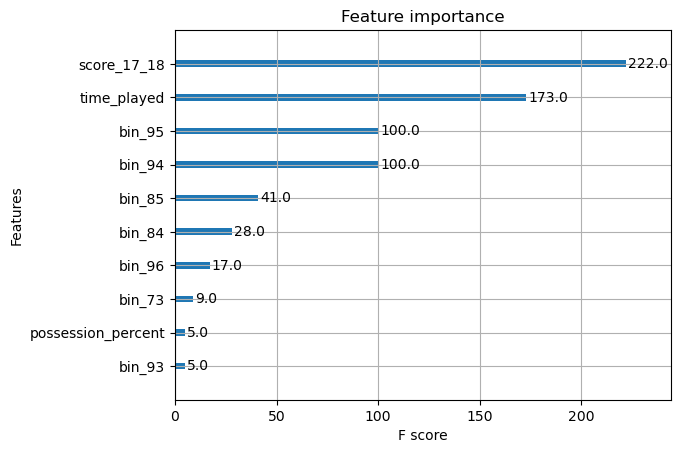

In [48]:
# Plottingg important features
# Plot feature importance
xgb.plot_importance(best_xgb_model)
plt.show()

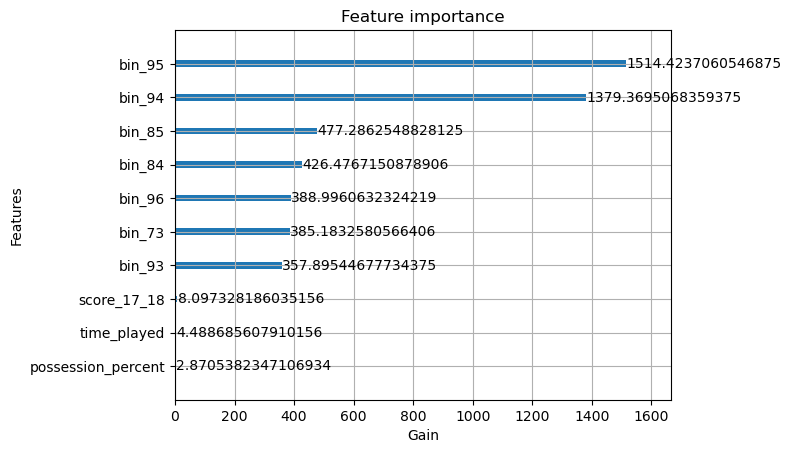

In [49]:
#We can also plot feature importance using two parameters:
# 1)gain: the 'gain' option displays the average gain of each feature when it is used in a tree

xgb.plot_importance(best_xgb_model, importance_type='gain', xlabel='Gain')
plt.show()

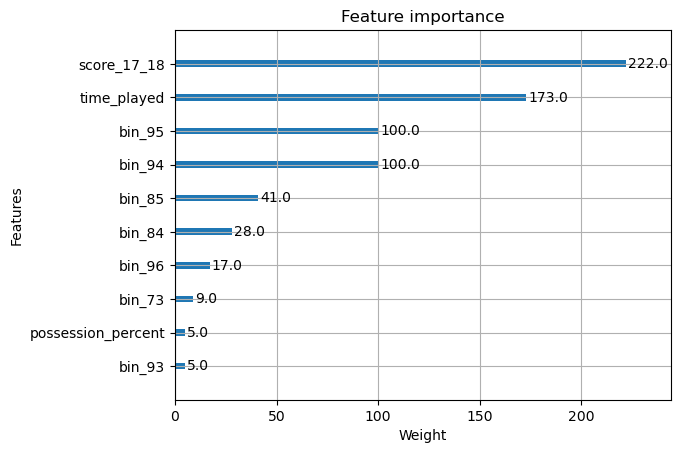

In [50]:
# 2)weight: The 'weight' option displays the number of times each feature appears in a tree

xgb.plot_importance(best_xgb_model, importance_type='weight', xlabel='Weight')
plt.show()

# Third Model : Random Forest

In [51]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [52]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
# Class imbalance in training data
weight_0 = count_class_0 / (count_class_0 + count_class_1)
weight_1 = count_class_1 / (count_class_0 + count_class_1)
print ('Weight of Shots Class in Training: ',weight_0)
print ('Weight of Goal Class in Training: ', weight_1)

Weight of Shots Class in Training:  0.8970380263984915
Weight of Goal Class in Training:  0.10296197360150848


In [53]:
# Define the hyperparameters to tune
param_grid = {'n_estimators': [100, 200, 300, 500],
              'max_depth': [5, 7, 9, 12],
              'min_samples_split': [5, 10, 12, 15, 17],
              'class_weight': ['balanced', {0: weight_0, 1: weight_1}]}

In [54]:
# Define the random forest model
rf_model = RandomForestClassifier()
start_time = time.time()
# Perform nested cross-validation with grid search
grid_rf = GridSearchCV(rf_model, param_grid=param_grid, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_rf = cross_val_score(grid, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

In [55]:
# Fit the best model on the entire training set
grid_rf.fit(X_train, y_train)
best_rf_model = grid_rf.best_estimator_

end_time = time.time()

rf_training_time = end_time - start_time

In [56]:
# Print the best parameters
print("Best parameters: ", grid_rf.best_params_)
print ("Model Training Time: {:.3f} seconds".format(rf_training_time))

Best parameters:  {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Model Training Time: 8853.098 seconds


In [57]:
# Brier score on training data
rf_brs_train = brier_score_loss(y_train, best_rf_model.predict_proba(X_train)[:, 1])
# Classfication report for training data and brier score
print (classification_report(y_train, best_rf_model.predict(X_train)),rf_brs_train, end= " is the brier score on training data" )

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     22835
           1       0.32      0.49      0.38      2621

    accuracy                           0.84     25456
   macro avg       0.63      0.68      0.65     25456
weighted avg       0.87      0.84      0.85     25456
 0.2116362828822115 is the brier score on training data

In [58]:
# Evaluate the performance of the best model on the testing set
y_pred_rf = best_rf_model.predict(X_test)
# Classfication report and brier score  for testing data
rf_brs_test = brier_score_loss(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print (classification_report(y_test, y_pred_rf), rf_brs_test, end= " is the brier score on testing data")

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      7654
           1       0.29      0.45      0.35       832

    accuracy                           0.84      8486
   macro avg       0.61      0.67      0.63      8486
weighted avg       0.87      0.84      0.85      8486
 0.21315186849726875 is the brier score on testing data

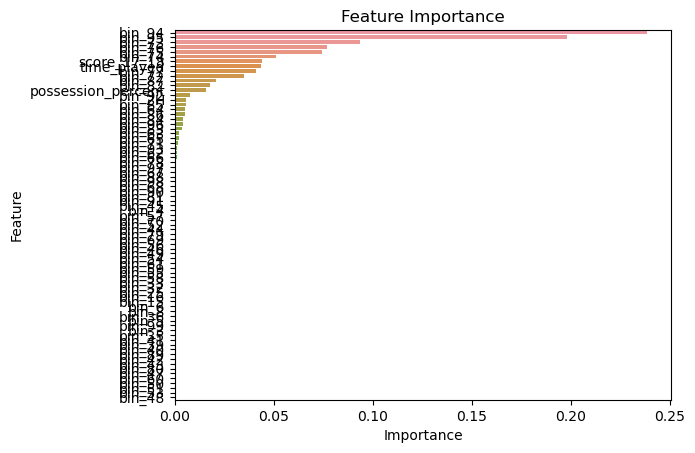

In [59]:
# Extract feature importances
importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Create barplot using seaborn
sns.barplot(x=importances[indices], y=names)

# Add x and y axis labels
plt.xlabel("Importance")
plt.ylabel("Feature")

# Show plot
plt.show()

In [60]:
# Precision scores for the four models on training data
prec_lr_train = precision_score(y_train, best_lr_model.predict(X_train))

prec_xgb_train = precision_score(y_train, best_xgb_model.predict(X_train))

prec_rf_train = precision_score(y_train, best_rf_model.predict(X_train))

#prec_svm_train = precision_score(y_train, best_svm_model.predict(X_train))

prec_train = [prec_lr_train, prec_xgb_train, prec_rf_train]

# Precision scores for the four models on testing data
prec_lr_test = precision_score(y_test, y_pred)

prec_xgb_test = precision_score(y_test, y_pred_xgb)

prec_rf_test = precision_score(y_test, y_pred_rf)

#prec_svm_test = precision_score(y_test, y_pred_svm)

prec_test = [prec_lr_test, prec_xgb_test, prec_rf_test]

# Recall scores for the four models on training data
rec_lr_train = recall_score(y_train, best_lr_model.predict(X_train))

rec_xgb_train = recall_score(y_train, best_xgb_model.predict(X_train))

rec_rf_train = recall_score(y_train, best_rf_model.predict(X_train))

#rec_svm_train = recall_score(y_train, best_svm_model.predict(X_train))

rec_train = [rec_lr_train, rec_xgb_train, rec_rf_train]


# Calculting Recall for the four models on test data
rec_lr_test = recall_score(y_test, y_pred)

rec_xgb_test = recall_score(y_test, y_pred_xgb)

rec_rf_test = recall_score(y_test, y_pred_rf)

#rec_svm_test = recall_score(y_test, y_pred_svm)

rec_test = [rec_lr_test, rec_xgb_test, rec_rf_test]

# Accuracy scores for the four models on training data
acc_lr_train = accuracy_score(y_train, best_lr_model.predict(X_train))

acc_xgb_train = accuracy_score(y_train, best_xgb_model.predict(X_train))

acc_rf_train = accuracy_score(y_train, best_rf_model.predict(X_train))

#acc_svm_train = accuracy_score(y_train, best_svm_model.predict(X_train))

acc_train = [acc_lr_train, acc_xgb_train, acc_rf_train]

# Calculating Accuracy for the four models on test data
acc_lr_test = accuracy_score(y_test, y_pred)

acc_xgb_test = accuracy_score(y_test, y_pred_xgb)

acc_rf_test = accuracy_score(y_test, y_pred_rf)

#acc_svm_test = accuracy_score(y_test, y_pred_svm)

acc_test = [acc_lr_test, acc_xgb_test, acc_rf_test]
# Brier score for four models on training data
BRS_train = [LR_BRS_train, xgb_BRS_train, rf_brs_train]
# Brier score for four models on test data
BRS_test = [LR_BRS_test, xgb_BRS_test, rf_brs_test]


# Model training time
train_time =[lr_training_time/60, xgb_training_time/60, rf_training_time/60]

In [61]:
# Creating of dataframe of summary results
summary_df = pd.DataFrame({'Model Name':['Logistic Regression','XG Boost','Random Forests'],
                          'Training Accuracy': acc_train, 'Training Precision': prec_train,'Training Recall':rec_train,'Training Brier': BRS_train,
                          'Testing Accuracy': acc_test, 'Testing Precision': prec_test,'Testing Recall':rec_test, 'Testing Brier': BRS_test,
                          'Training Time (mins)': train_time})

summary_df.set_index('Model Name', inplace=True)
# Displaying summary of results
summary_df.style.format(precision =3).highlight_max(color='cyan').set_properties(**{'font-weight': 'bold',
            'border': '2.0px solid grey','color': 'purple'}).highlight_min(color='yellow')

,Training Accuracy,Training Precision,Training Recall,Training Brier,Testing Accuracy,Testing Precision,Testing Recall,Testing Brier,Training Time (mins)
Model Name,,,,,,,,,
Logistic Regression,0.661,0.198,0.751,0.192,0.664,0.189,0.739,0.193,1.251
XG Boost,0.868,0.368,0.397,0.210,0.867,0.344,0.391,0.211,17.768
Random Forests,0.838,0.315,0.490,0.212,0.835,0.286,0.454,0.213,147.552


In [63]:
pickle.dump(best_lr_model, open('xG_model.pkl', 'wb'))